In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matlab.engine # to run Cheng's code
import os

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import data_handler_03 as dh
import my_simgraph_06 as sg
import assess_simgraph_06_lmnn_lgrg as asg

In [ ]:
import importlib
importlib.reload(asg)

# Load and group neuron spike data

In [2]:
# load all spike data from file
spikes_dp = '../../data/original_files/spikes.csv'
binned_data = np.loadtxt(spikes_dp, delimiter=',')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1     # turn labels from 0,1 to -1,1

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

# group all neurons together
grouped_data = np.zeros((297, 1141, 1))
for trial in range(297):
    for frame in range(1141):
        grouped_data[trial, frame, :] = 2 * int((binned_data[trial, frame, :] == 1).any()) - 1

# Assess the model's performance with random tests

In [14]:
def datapoint_parham(index, data_params):
    """
    Return a single datapoint consisting of (feature vector, label) 
    based on the extended index system of the whole dataset (297 repeats of a 1141-frame movie); 
    for example, the 6th frame of the 7th repeat is indexed 7*1141+5. 
    In this system, indices only move forward after repeats, so they represent time in a sense.
    Acceptable index range is batch_sz-1 to 1141*297-1.
      
    Inputs: index, data_params
    index - chosen datapoint's index
    data_params   -
        func - funtion which returns a datapoint (fv, lbl) based on its index
        features_dp - path to where feature vectors are stored
        spike_data - (297 x 1141 x m)-shaped array where m is the number of subgroups of neurons.
        group_id - index of the chosen subgroup of neurons which is being considered
        transform - func. applied to the original feature vector (defult: None, no transform is applied)
            
    
    Output: fv, lbl
    fv  - Dfx1 vector representing the selected time bin's feature vector
    lbl - the selected time bin's label
    """
    # unpack params
    features_dp = data_params['features_dp']
    lbl_func = data_params['lbl_func']
    transform = data_params['transform'] if 'transform' in data_params else None
    
    # feature vector
    # trial = index//1141
    frame = index%1141
    fvs = np.load(features_dp)
    fv = fvs[frame - 41]
    if transform is not None:
        fv = transform(fv)

    # label  
    lbls = lbl_func(data_params)
    lbl = lbls[index]
    
    return fv, lbl

def get_mnist_labels(data_params):
    return np.loadtxt(data_params['features_dp']+'lbls.csv')

def transform_siftmnist(fv):
    return fv[::16]

def transform_sift3d(fv):
    return fv[::10]

def transform_slowfast(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[::10]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

# data retrieval params
# data_params = {'func': dh.datapoint_sift, 'lbl_func': get_mnist_labels, 'features_dp': '../../data/fe_exp/mnist-sift/', \
#                'spike_data': None, 'group_id': None, 'transform': transform_siftmnist, 'ind_min': 0, 'ind_max': 13203}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/slowfast/slowfast_4732_numpy/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_slowfast, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1}

# data retrieval params - using layer2 features
data_params = {'func': datapoint_parham, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/parham/parham2/features_test_2layer.npy', \
               'spike_data': grouped_data, 'group_id': 0, 'transform': None, 'ind_min': 1*1141+41, 'ind_max': 2*1141-1}

# graph construction and penalty term parameters
sg_params = {'mu': 30, 'Dt': 8, 'Dv':0, 'Dvt':3000, \
             'cnstr_method_tt': 'random', 'cnstr_method_vv': 'random', 'cnstr_method_vt': 'random',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters
sg_opt_params = {}

# randomization parameters
rnd_params = {'train_sizes': [50, 100, 150, 200], 'val_sizes': [100], 'train_its': 5, 'val_its': 10, 'seed': None}
# rnd_params = {'train_sizes': [400], 'val_sizes': [10], 'train_its': 2, 'val_its': 3, 'seed': None}

# parameters to visualize the optimized M
f_sz = 474 # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 30, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}

# # start a matlab engine to run Cheng's code
# eng = matlab.engine.start_matlab()
# eng.cd(r'/home/yasamanparhizkar/Documents/yorku/01_thesis/code/15_cheng', nargout=0)

# path to save the results
res_path_sg = '../../data/experiments/comparison/temp/lmnncvx/'
res_path_lgrg = '../../data/experiments/comparison/temp/lgrg/'

gamma = 1
beta = 1

In [4]:
eng = matlab.engine.start_matlab()
eng.cd(r'../15_cheng/lmnn-offtheshelf/', nargout=0)

In [8]:
# import importlib
# importlib.reload(sg)
# importlib.reload(asg)

-> Iteration ID: 100_50_0
   It is being overwritten.
> In cvxprob (line 28)
In cvx_begin (line 41)
In lmnn_cvx_python (line 31)
cvx_status:  Failed


IndexError: boolean index did not match indexed array along dimension 0; dimension is 474 but corresponding boolean dimension is 400

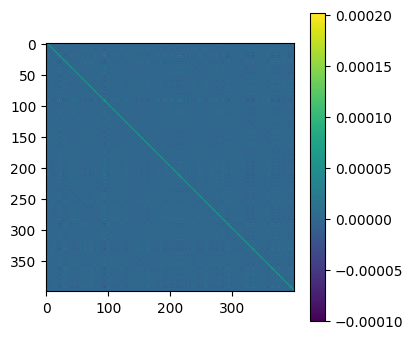

In [15]:
val_num_res_sg, val_num_err_sg, val_num_res_lgrg, val_num_err_lgrg = asg.assess_sg_model(eng, gamma, beta, data_params, sg_params, sg_opt_params, rnd_params, fig_params, res_path_sg, res_path_lgrg)

In [ ]:
asg.plot_curves(rnd_params, sg_params, res_path_sg)

In [ ]:
asg.plot_curves_without_runtime(rnd_params, sg_params, res_path_lgrg)

In [ ]:
# # close the matlab engine when you're done
# eng.quit()

# Plot similarity graph and logistic regression validation accuracies together

In [ ]:
# unpack params
train_sizes = rnd_params['train_sizes']
val_sizes = rnd_params['val_sizes']
train_its = rnd_params['train_its']
val_its = rnd_params['val_its']
assess_qs = ['min_acc', 'val_acc', 'missed', 'false_alarm']

# read sg training curves
curves_sg = {}
errors_sg = {}
for i in range(len(val_sizes)):
    curves_i = np.loadtxt(res_path_sg+'curves/train_'+str(i)+'.txt')
    j = 0
    for quantity in assess_qs:
        if i==0:
            curves_sg[quantity] = curves_i[j::8].reshape((1, -1))
            errors_sg[quantity] = curves_i[j+1::8].reshape((1, -1))
        else:
            curves_sg[quantity] = np.concatenate((curves[quantity], [curves_i[j::8]]), axis=0)
            errors_sg[quantity] = np.concatenate((errors[quantity], [curves_i[j+1::8]]), axis=0)
        j += 2
        
# read lgrg training curves
curves_lgrg = {}
errors_lgrg = {}
for i in range(len(val_sizes)):
    curves_i = np.loadtxt(res_path_lgrg+'curves/train_'+str(i)+'.txt')
    j = 0
    for quantity in assess_qs:
        if i==0:
            curves_lgrg[quantity] = curves_i[j::8].reshape((1, -1))
            errors_lgrg[quantity] = curves_i[j+1::8].reshape((1, -1))
        else:
            curves_lgrg[quantity] = np.concatenate((curves[quantity], [curves_i[j::8]]), axis=0)
            errors_lgrg[quantity] = np.concatenate((errors[quantity], [curves_i[j+1::8]]), axis=0)
        j += 2

# plot training curves
plt.figure(figsize=(7,4))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.8,hspace=0.8)
for i in range(len(val_sizes)):
    plt.subplot(len(val_sizes), 1, i+1)
    plt.errorbar(train_sizes, curves_sg['val_acc'][i], errors_sg['val_acc'][i])
    plt.errorbar(train_sizes, curves_lgrg['val_acc'][i], errors_lgrg['val_acc'][i])
    plt.legend(['sg', 'lgrg'])
    plt.xlabel('training set size')
    plt.ylabel('{} val repeats x {} train repeats'.format(val_its, train_its))
    _ = plt.title('val. set size = {}, Dt = {}, Dvt = {}, Dv = {}'.format(val_sizes[i], sg_params['Dt'], sg_params['Dvt'], sg_params['Dv']))
plt.savefig(res_path_sg+'val_acc_compare.png')